In [490]:
import pandas as pd
import sqlite3
import numpy as np
from sklearn.metrics import pairwise_distances

In [524]:
import numpy as np
import scipy.sparse
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
import sqlite3
from sklearn.metrics import pairwise_distances


class Method1:
    
    def __init__(self, Lyrics="TrackData.csv", Track_Song_Mappings = "Song-Track.csv", Words="Words.txt", Database = "track_metadata.db", Encodings="Encodings_numpy.pickle.npy"):
        
        print("Loading TrackIDs, SongIDs, and Lyrics..")
        self.track_lyrics_df = pd.read_csv(Lyrics)
        self.song_track_df = pd.read_csv(Track_Song_Mappings)
        self.song_track_df = self.song_track_df.rename(columns={'TrackID':'ID'})
        self.track_lyrics_df = self.track_lyrics_df.merge(self.song_track_df)
        self.song_track_df = []
        
        
        

        print("Loading Words..")
        self.words = {}
        f = open(Words)
        for line in f:
            words = line.split(",")
            for i, word in enumerate(words):
                self.words[i+1] = word
        
        print("Loading Track Database..")
        self.db_conn = sqlite3.connect('track_metadata.db')
        
        print("Loading KDD Tree for Lyrics Similarity..")
        self.enc = np.load(Encodings, allow_pickle=True)
        self.tree = KDTree(self.enc, leaf_size=40) 
        
        self.similarSongs = []
        self.temp = pd.DataFrame()
        
        print("Loaded!")
        
        
        
    def getLyrics(self, embeddings, words, with_count = False):
        sentence = ""
  
        embeddings = embeddings.replace("[","")
        embeddings = embeddings.replace("]","")
        embeddings = embeddings.replace("'","")
        embeddings = embeddings.replace(" ","")
        embeddings = embeddings.split(",")

        for emb in embeddings:
            ids = emb.split(":")
            sentence += words[int(ids[0])] + " "

        return sentence
    
    def ShowSongs(self, ret = False, feature = 'Title'):
        songs = self.track_lyrics_df[feature].unique()
        if ret == False:
            print(songs)
        else:
            return songs
        
    def getLyricsSimilarity(self, song, typ = 'Title', k=5):

            index = self.track_lyrics_df[self.track_lyrics_df[typ] == song].index[0]
    
            dist, ind = self.tree.query(self.enc[index:index+1], k=int(k)+1)
            self.similarSongs = ind[0]

            self.temp = self.track_lyrics_df[self.track_lyrics_df.index.isin(self.similarSongs)]
            #for row in temp:
                #print("Song: " + row[3] + ", Artist: " + row[4])
            for row in self.temp[['Title','Artist name']].values:
                print("Song:",row[0],", Artist:",row[1])
        
        #except:
        #    print("Unkown Song")
        
    
    def getSimilarTrackID(self, song, typ = 'Title', k=5):
        
        if self.temp.empty:
            index = self.track_lyrics_df[self.track_lyrics_df[typ] == song].index[0]
    
            dist, ind = self.tree.query(self.enc[index:index+1], k=int(k)+1)
            self.similarSongs = ind[0]

            self.temp = self.track_lyrics_df[self.track_lyrics_df.index.isin(self.similarSongs)]
            
        
        return self.temp['ID'].values
    
    
    def getSimilarSongID(self, song, typ = 'Title', k=5):
        
        try:
            index = self.track_lyrics_df[self.track_lyrics_df[typ] == song].index[0]
        except:
            return [-1]
    
        dist, ind = self.tree.query(self.enc[index:index+1], k=int(k)+1)
        self.similarSongs = ind[0]

        self.temp = self.track_lyrics_df[self.track_lyrics_df.index.isin(self.similarSongs)]
            
        
        return self.temp['SongID'].values
    
        
    def RecommendSongs(self, song, typ = 'Title', k=5):
        
        #song = input()
        self.getLyricsSimilarity(song, typ, int(k))
        
    
    def PairwiseDistanceEvaluation(self, song, typ = 'Title', k=5):
    
        similar_songs = self.getSimilarSongID(song, typ, k)
        
        try:
            idx = self.track_lyrics_df[self.track_lyrics_df[typ] == song].index[0]
            song_emb = self.enc[idx]
            #print("Here")
        except:
            return [-1]
        
        closeness = []
        
        for s in similar_songs:
            idx = self.track_lyrics_df[self.track_lyrics_df['SongID'] == s].index[0]
            sim_emb = self.enc[idx]
            dist = pairwise_distances(song_emb.reshape(-1,len(self.enc[0])),sim_emb.reshape(-1,len(self.enc[0])), metric='cosine')[0][0]
            closeness.append(dist)
            
        return closeness
        
            
            
    
    def LyricCloud(self):
        
        if len(self.similarSongs) == 0:
            print("Choose Song..")
            self.RecommendSongs()
            
        temp = pd.DataFrame()
        temp['Sentence'] = self.temp['Lyrics'].apply(lambda x: self.getLyrics(x, self.words))
        stopwords = set(STOPWORDS)
        comment_words = ""

        # iterate through the csv file
        for val in temp.Sentence:

            # typecaste each val to string
            val = str(val)

            # split the value
            tokens = val.split()

            # Converts each token into lowercase
            for i in range(len(tokens)):
                tokens[i] = tokens[i].lower()

            comment_words += " ".join(tokens)+" "
            
        
        wordcloud = WordCloud(width = 800, height = 800, background_color ='white',
                              stopwords = stopwords, min_font_size = 10).generate(comment_words)
 
        # plot the WordCloud image                      
        plt.figure(figsize = (5, 5), facecolor = None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)
        plt.show()

        

In [525]:
model = Method1()

Loading TrackIDs, SongIDs, and Lyrics..
Loading Words..
Loading Track Database..
Loading KDD Tree for Lyrics Similarity..
Loaded!


In [46]:
model.ShowSongs()

['A Poor Recipe For Civic Cohesion' 'Soul Deep' "It's About Time" ...
 'No Angels' 'Dear Lie' 'Trans-Island Skyway (Album Version)']


In [14]:
model.RecommendSongs('A Poor Recipe For Civic Cohesion',5)

Song: A Poor Recipe For Civic Cohesion , Artist: Western Addiction
Song: Scavenger Of Human Sorrow , Artist: Death
Song: River Of Deceit , Artist: Mad Season
Song: Eleven Miles Out , Artist: Doves
Song: On the Throne , Artist: Altar
Song: Nebraska , Artist: The Lawrence Arms


In [526]:
model.PairwiseDistanceEvaluation(song='SODQUIP12A67020FD2',typ='SongID',k= 5)

[0.07714927, 0.074038506, 0.08459395, 0.07776344, 0.0796175, 1.7881393e-07]

In [527]:
pairwise_distances(model.enc[1].reshape(-1,len(model.enc[0])),model.enc[10].reshape(-1,len(model.enc[0])), metric='cosine')[0][0]

0.31306165

In [546]:
def EvaluateLyricsSimilarity(model=model, k=5):
    #print(k)
    temp_df = model.track_lyrics_df['SongID'].sample(int(k))
    SongIDs = temp_df.values
    
    closeness = []
    
    for s in tqdm(SongIDs):
        cls = model.PairwiseDistanceEvaluation(song=s,typ='SongID',k= 5)
        closeness.append(np.mean(cls))
    
    print("Lyrics similarity for recommended songs for " + str(k) + " songs: ", np.mean(closeness))
        
        

In [548]:
EvaluateLyricsSimilarity(model=model, k=500)

100%|██████████| 500/500 [04:08<00:00,  2.01it/s]

Lyrics similarity for recommended songs for 500 songs:  0.06872204


In [3]:
user = pd.read_csv("train_triplets.txt",sep="\t",names=['User','SongID','Count'])
test_user = pd.read_csv("test_users.csv")
song_track = pd.read_csv("Song-Track.csv")
user = user[user['User'].isin(test_user['User'].values)] 

In [45]:
print(user.shape)
user.head()

(48373586, 3)


,User,SongID,Count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [44]:
print(test_user.shape)
test_user.head()

(203864, 2)


,User,Count
0,8e6949d1633baab45cb05dedc1730d400acad51f,86
1,c663806c68df5e0172ab48628bdfb6005ad60d40,12
2,d8398c5a9a7d8a7bf1c05b8797b2e758211df137,15
3,eeafb3512afb8b876540bfe116505574fb36e8e3,356
4,e731d8a6826db516f6b53725d7a46a43d586da93,29


In [5]:
user.shape

(9645956, 3)

In [6]:
len(user[user['SongID'].isin(song_track['SongID'].values)]['SongID'].unique())

304773

In [7]:
len(user['SongID'].unique())

304773

In [9]:
trackdata = pd.read_csv("trackdata.csv")
trackdata = trackdata.rename(columns={'ID':'TrackID'})
print(trackdata.shape)
trackdata.head()

(210519, 5)


,TrackID,MXM,Lyrics,Title,Artist name
0,TRAAAAV128F421A322,4623710,"['1:6', '2:4', '3:2', '4:2', '5:5', '6:3', '7:...",A Poor Recipe For Civic Cohesion,Western Addiction
1,TRAAABD128F429CF47,6477168,"['1:10', '3:17', '4:8', '5:2', '6:2', '7:1', '...",Soul Deep,The Box Tops
2,TRAAAED128E0783FAB,2516445,"['1:28', '2:15', '3:2', '4:12', '5:22', '6:2',...",It's About Time,Jamie Cullum
3,TRAAAEF128F4273421,3759847,"['1:5', '2:4', '3:3', '4:2', '5:1', '6:11', '9...",Something Girls,Adam Ant
4,TRAAAEW128F42930C0,3783760,"['1:4', '4:5', '5:7', '6:2', '7:4', '9:1', '10...",Burn My Body (Album Version),Broken Spindles


In [10]:
trackdata.merge(song_track).shape

(210519, 6)

In [27]:
songs = model.ShowSongs(ret=True, feature='SongID')
len(songs)

210519

In [26]:
len(model.track_lyrics_df['SongID'].unique())

210519

In [41]:
import random

k = 100
test_songs = random.sample(set(songs),k)



In [ ]:
for s in test_songs:
    model.getSimilarSongID(song=s, typ='SongID', k=5)
    

In [128]:
pred = model.getSimilarSongID(song=popular_songs_list[0], typ='SongID', k=10)
print(pred)
print(test_songs[6])

['SOMTAKS12AC468DDC1' 'SOCJLHI12AB018B0B0' 'SOISBTJ12AB018FFB6'
 'SOTALRK12A8C132E4B' 'SOPPFSD12AB0182EC5' 'SOVQTRT12AB018783D'
 'SOSTQAE12A8C145C4A' 'SOQJUHY12A67ADD62A' 'SOAFCNP12A6D4FADCD'
 'SOYYZMS12A6D22823A' 'SOLXDQY12AB0183272']
SOYYZMS12A6D22823A


In [147]:
popular_songs = user.groupby('SongID').agg({'SongID':'size'}).rename(columns={'SongID':'Users'})
popular_songs = popular_songs.reset_index()

In [151]:
popular_songs = popular_songs.sort_values(by=['Users'], ascending=False)
popular_songs_list = popular_songs['SongID'].head(50).to_list()
popular_songs 

,SongID,Users
71703,SOFRQTD12A81C233C0,22083
11377,SOAXGDH12A8C13F8A1,18076
10269,SOAUWYT12A81C206F1,17749
19789,SOBONKR12A58A7A7E0,16485
227579,SOSXLTC12AF72A7F54,16080
...,...,...
86640,SOGWYLG12A8C139C49,1
86641,SOGWYNO12A8C145D4D,1
157172,SOMTEBW12A8C1381EF,1
157232,SOMTHFU12A8C132013,1


In [169]:
tot = user[user['User'].isin(user[user['SongID'] == popular_songs_list[5]]['User'].unique())]['SongID'].unique()

In [170]:
user[user['SongID'] == popular_songs_list[5]]

,User,SongID,Count
3842,8cbb5066924ec788e3fea9a4aae59586f46f38fa,SONYKOW12AB01849C9,1
5288,2f343c8bd0502c4cf851a6970e47d296a4b76d5b,SONYKOW12AB01849C9,1
7043,a520488fcf049bbb5cd847cfa4f884c740692780,SONYKOW12AB01849C9,1
9152,7d0317ddb859a960cb4836e7c7e9982a54fd64e2,SONYKOW12AB01849C9,1
10007,8caf9a87e266a22298bd977a63489d008af241c5,SONYKOW12AB01849C9,4
...,...,...,...
48354589,4020fc2964bb39d2175b875a06aea642e42dc6af,SONYKOW12AB01849C9,2
48361447,72b4b67956ab6d4ff66d9981dc8bb90d07181e1e,SONYKOW12AB01849C9,8
48363129,59f73d338d87898f5da11d5c3d5d61f27987ba74,SONYKOW12AB01849C9,1
48367576,f05365567be5ef581c5836dbaf9a38fd78dcc3bb,SONYKOW12AB01849C9,1


In [158]:
popular_songs_list[2]

'SOAUWYT12A81C206F1'

In [168]:
pred = model.getSimilarSongID(song=popular_songs_list[5], typ='SongID', k=5)
print(pred)
print(popular_songs_list[0])

['SOLYAYO12A8C13C04D' 'SOTNKMR12A8C140F33' 'SONYKOW12AB01849C9'
 'SORQGDL12AB0181C33' 'SOUFGTT12AB017C1D7' 'SOFIWRN12AB0186819']
SOFRQTD12A81C233C0


In [171]:
i = 0

for j in pred:
    if j in tot:
        i+=1
i

2

In [73]:
pred

array(['SOQPWCR12A6D4FB2A3', 'SOXZKKZ12A8C13D5BA', 'SOIKPOV12A58A7A6B2',
       'SOJKDDZ12AC9097781', 'SODQUIP12A67020FD2', 'SOEFSIL12A58A804A5'],
      dtype=object)

In [68]:
tot

array(['SOARUPP12AB01842E0', 'SOASTSF12A8C1420B5', 'SOBDWPN12A8C13F43C',
       ..., 'SOYUFMA12A8C139FEC', 'SOZDAAD12A8C146C0E',
       'SOZYWKE12A8C13F11D'], dtype=object)

In [78]:
test_songs[1]

'SOWOGRM12A8C133D98'

In [102]:
model.RecommendSongs(song='On the Throne', typ='Title', k=5)

Song: Janus (Riff Monster - topical) , Artist: The Gone Jackals
Song: No Turn Un-Stoned , Artist: Shpongle
Song: Freak Out! (Album) , Artist: Every Avenue
Song: Killer From The Deep , Artist: Evile
Song: One Way Out , Artist: Rob Rock
Song: On the Throne , Artist: Altar


## Evaluation 1:

In [574]:
from tqdm import tqdm

def Evaluate1(k=500, user_k=10):
    
    popular_songs = user.groupby('SongID').agg({'SongID':'size'}).rename(columns={'SongID':'Users'})
    popular_songs = popular_songs.reset_index()
    popular_songs = popular_songs.sort_values(by=['Users'], ascending=False)
    popular_songs_list = popular_songs['SongID'].head(k).to_list()
    
    not_in_model = 0
    users_who_listened = []
    fraction = []
    
    for s in tqdm(popular_songs_list):
        
        pred = model.getSimilarSongID(song=s, typ='SongID', k=10)
        #print(s, pred)

        if pred[0] == -1:
            not_in_model +=1
            continue
          
        
        for ind in range(len(pred)):
            if s == pred[ind]:
                #print(pred, ind)
                p = np.delete(pred, ind)
                #print(p)
          
        user_list = user[user['SongID'] == s].sort_values(by=['Count'],ascending=False)
        user_list = user_list.head(user_k)

        user_list = user_list['User'].values
        tot = user[user['User'].isin(user_list)]
        count = len(tot[tot['SongID'].isin(p)]['User'].unique())
        frac = len(user_list)

        
        users_who_listened.append(count)
        fraction.append(frac)
        
    
    return users_who_listened, fraction, not_in_model
        

In [575]:
a, b, c = Evaluate1()

100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


In [576]:
res = [(i / j)*100 for i, j in zip(a, b)]
print("Evaluation 1 accuracy with all users:",np.mean(res))
print("Evaluation 1 accuracy for at least one of the top k users:",np.mean(a)*100)

Evaluation 1 accuracy with all users: 0.8189655172413793
Evaluation 1 accuracy for at least one of the top k users: 8.189655172413794


In [250]:
user_user = np.load("user_user_similar.pkl", allow_pickle=True)

In [254]:
np.shape(user_user)

(384546, 5)

In [255]:
user_dup = pd.read_csv("train_triplets.txt",sep="\t",names=['User','SongID','Count'])

In [256]:
len(user_dup['User'].unique())

1019318

In [265]:
user_user[9000]

array([  3090,  73960, 337689, 379576,   9000])

In [261]:
users = np.array(list(np.sort(user_dup['User'].unique())))

In [263]:
len(users)

1019318

In [268]:
rows = user_dup['User'].astype(CategoricalDtype(categories=users)).cat.codes

In [270]:
len(rows.unique())

1019318

In [273]:
np.max(user_user)

384545

In [276]:
user_user[100]

array([ 68706, 287546,     44,  73190,    100])

In [277]:
import pickle

loaded_model = pickle.load(open("svd_model.pkl", 'rb'))

In [278]:
user_dup['User'].values[0]

'b80344d063b5ccb3212f76538f3d9e43d87dca9e'

In [293]:
pred = loaded_model.predict(uid=user_dup['User'].values[0], iid=user_dup['SongID'].values[0])
pred

Prediction(uid='b80344d063b5ccb3212f76538f3d9e43d87dca9e', iid='SOAKIMP12A8C130995', r_ui=None, est=9, details={'was_impossible': False})

In [291]:
pred

Prediction(uid='8caf9a87e266a22298bd977a63489d008af241c5', iid='SOYYWMD12A58A7BCC9', r_ui=None, est=9, details={'was_impossible': False})

In [316]:
us = user_dup[user_dup['Count'] > 10].groupby('Count').agg({'Count':'size'}).rename(columns={'Count':'Users-Song'})

<AxesSubplot:>

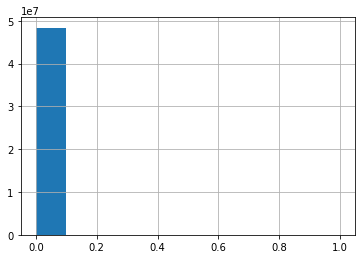

In [318]:
user_dup['Frac'] = user_dup['Count']/user_dup['Count'].max()


<AxesSubplot:>

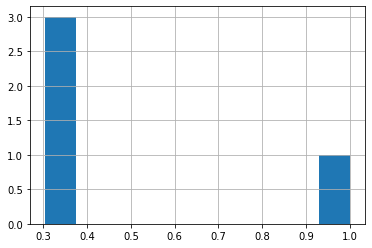

In [321]:
user_dup[user_dup['Frac']>0.3]['Frac'].hist()

In [317]:
user_dup['Count'].max()

9667

In [326]:
us[us["Users-Song"]<500]

,Users-Song
Count,
98,492
101,451
102,453
103,409
104,467
...,...
2381,1
2948,1
3532,1


In [336]:
bins = pd.IntervalIndex.from_tuples([(0, 10), (11, 20), (21, 30), (31, 40), (41, 50), (51, 60), (61, 70), (71, 80), (81, 90), (91,10000)])
pd.cut([0, 0.5, 91.5, 2.5, 4.5], bins, labels=[1,2,3,4,5,6,7,8,9,10])

[NaN, (0.0, 10.0], (91.0, 10000.0], (0.0, 10.0], (0.0, 10.0]]
Categories (10, interval[int64]): [(0, 10] < (11, 20] < (21, 30] < (31, 40] ... (61, 70] < (71, 80] < (81, 90] < (91, 10000]]

In [329]:
us[us.index==100]

,Users-Song
Count,
100,506


In [333]:
pd.cut(user_dup['Count'],10,labels=[1,2,3,4,5,6,7,8,9,10]).value_counts()

1     48373519
2           57
3            6
4            3
10           1
9            0
8            0
7            0
6            0
5            0
Name: Count, dtype: int64

In [334]:
user_dup[user_dup['Count'] > 50]

,User,SongID,Count,Frac
2209,3f152d355d53865a2ca27ac5ceeffb7ebaea0a26,SOYZLWW12AB0186148,55,0.005689
2213,3f152d355d53865a2ca27ac5ceeffb7ebaea0a26,SOZFYTZ12AB018565D,52,0.005379
2632,43683da3c6c5a93c7938ff550faf0d039a9a639a,SOUEAYG12A6D4FE4AF,126,0.013034
2908,99b5f915dd56a0150eb91605e1f6109e1e80c9de,SOBONKR12A58A7A7E0,58,0.006000
3186,edc8b7b1fd592a3b69c3d823a742e1a064abec95,SOURSIU12A8C140B9A,77,0.007965
...,...,...,...,...
48369829,0f4e408968413371e7d487bc78e92259e403349f,SOJTWGB12A58A7ADFB,92,0.009517
48371405,27604dd5e034cc07ce60d201c3c22377415de352,SODAJWB12A8C13BE3E,58,0.006000
48371413,27604dd5e034cc07ce60d201c3c22377415de352,SOMMIXC12A6D4F9EF0,261,0.026999
48371414,27604dd5e034cc07ce60d201c3c22377415de352,SONGEAP12AB01891CD,55,0.005689


In [340]:
def Group(x):
    
    if x<2:
        return 0
    elif x<10:
        return 1
    elif x<20:
        return 2
    elif x<30:
        return 3
    elif x<40:
        return 4
    elif x<50:
        return 5
    elif x<60:
        return 6
    elif x<70:
        return 7
    elif x<80:
        return 8
    elif x<90:
        return 9
    else:
        return 10

In [341]:
user_dup['Cat'] = user_dup['Count'].map(Group)

In [342]:
user_dup['Cat'].value_counts()

0     28755966
1     17140061
2      1741665
3       407091
4       151384
5        70377
6        37635
10       25328
7        21672
8        13503
9         8904
Name: Cat, dtype: int64

<AxesSubplot:>

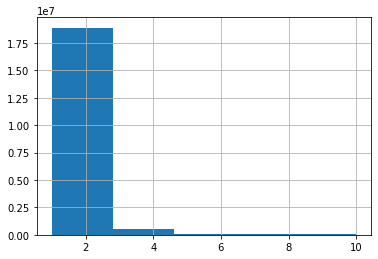

In [348]:
user_dup[user_dup['Cat'] > 0]['Cat'].hist(bins=5)

## Evaluation 2:

* Select Random popular songs.
* For a song,
    * Select k users who listen to this song frequently.
    * Recommend songs.
    * Find top 5 similar users for k users. 
    * Check if they had listened to this song.
  

In [ ]:
from pandas.api.types import CategoricalDtype

In [ ]:
user_dup = pd.read_csv("train_triplets.txt",sep="\t",names=['User','SongID','Count'])
user_user = np.load("user_user_similar.pkl", allow_pickle=True)

In [ ]:
users = np.array(list(np.sort(user_dup['User'].unique())))
rows = user_dup['User'].astype(CategoricalDtype(categories=users)).cat.codes

In [437]:
from tqdm import tqdm

def ind_to_user(x):
    return users[x]

def Evaluate2(songs_k = 50, user_k=10):
    
    popular_songs = user.groupby('SongID').agg({'SongID':'size'}).rename(columns={'SongID':'Users'})
    popular_songs = popular_songs.reset_index()
    popular_songs = popular_songs.sample(10000)
    popular_songs = popular_songs.sort_values(by=['Users'], ascending=False)
    popular_songs_list = popular_songs['SongID'].head(songs_k).to_list()
    
    not_in_model = 0
    users_who_listened = []
    fraction = []
    unknown_users = 0

    
    overall_acc = []
    
    for s in tqdm(popular_songs_list):
        print("Song: ", s)
        
        pred = model.getSimilarSongID(song=s, typ='SongID', k=10)
        #print(s, pred)

        if pred[0] == -1:
            not_in_model +=1
            continue
          
        
        for ind in range(len(pred)):
            if s == pred[ind]:
                #print(pred, ind)
                p = np.delete(pred, ind)
                #print(p)
          
        user_list = user[user['SongID'] == s].sort_values(by=['Count'],ascending=False)
        user_list = user_list.head(user_k)
        user_list = user_list['User'].values
        
        song_accuracy = []
        i = 0
        print("Total Users: ", len(user_list))
        for u in user_list:
            print("User:",i)
            i+=1
            try:
                ind = np.where(users == u)[0][0]
            except:
                unknown_users +=1
                continue
            try:
                sim_users = user_user[ind]
                sim_users = list(map(ind_to_user,sim_users))
            except:
                unknown_users +=1
                continue
            
            accuracy = 0
            
            print("Checking Similar Users..")
            
            for sim_u in sim_users:
                temp_songs = user[user['User'] == sim_u]['SongID'].unique()
                acc = 0
                for s_id in p:
                    if s_id in temp_songs:
                        print("MATCH")
                        acc+=1
                        break
                    if acc==1:
                        break
                        
                accuracy += acc
                    
            
            song_accuracy.append(accuracy)
            
        if len(song_accuracy) > 0:    
            perc = np.mean(song_accuracy)
            overall_acc.append(perc)

        
    
    return overall_acc, unknown_users, not_in_model
        

In [439]:
acc, ukn_users, ukn_songs = Evaluate2(songs_k = 50, user_k=10)

  0%|          | 0/50 [00:00<?, ?it/s]

Song:  SOUSMXX12AB0185C24
Song:  SOPUCYA12A8C13A694
Total Users:  10
User: 0
User: 1
Checking Similar Users..
User: 2
User: 3
User: 4
User: 5
User: 6
Checking Similar Users..


  4%|▍         | 2/50 [00:12<04:48,  6.00s/it]

User: 7
User: 8
User: 9
Song:  SOEPZQS12A8C1436C7
Song:  SOYMIMI12AB0181E5C
Total Users:  10
User: 0
Checking Similar Users..
User: 1
User: 2
User: 3
User: 4
User: 5
Checking Similar Users..
User: 6
User: 7
Checking Similar Users..
User: 8
Checking Similar Users..


  8%|▊         | 4/50 [00:29<05:14,  6.83s/it]

User: 9
Song:  SOLCKAS12A8C14242A
Song:  SOVRTPN12AB0184F9E
Total Users:  10
User: 0
User: 1
User: 2
User: 3
User: 4
User: 5
User: 6
User: 7
Checking Similar Users..
User: 8
Checking Similar Users..


 12%|█▏        | 6/50 [00:39<04:38,  6.32s/it]

User: 9
Song:  SOYGHOJ12A6701FFBA
Song:  SOLWRZI12A6D4FC4F0
Total Users:  10
User: 0
User: 1
Checking Similar Users..
User: 2
User: 3
User: 4
User: 5
Checking Similar Users..
User: 6
Checking Similar Users..
User: 7
Checking Similar Users..
User: 8
Checking Similar Users..


 18%|█▊        | 9/50 [01:04<03:56,  5.76s/it]

User: 9
Song:  SOIEBXT12A8C1341E1
Song:  SOGFFET12A58A7ECA9
Total Users:  10
User: 0
Checking Similar Users..
User: 1
Checking Similar Users..
User: 2
User: 3
Checking Similar Users..
User: 4
User: 5
User: 6
Checking Similar Users..


 20%|██        | 10/50 [01:35<08:50, 13.26s/it]

User: 7
User: 8
User: 9
Song:  SOHNVHC12A6D4F95AB
Total Users:  10
User: 0
User: 1
User: 2
User: 3
Checking Similar Users..
User: 4
User: 5
Checking Similar Users..
User: 6
Checking Similar Users..
User: 7
User: 8
User: 9
Checking Similar Users..


 22%|██▏       | 11/50 [01:55<10:03, 15.46s/it]

Song:  SOETKSY12A8C13C666
Song:  SONTQUO12A6D4F7D8B
Song:  SOZHUUI12A6701D7B6
Song:  SOVOOSP12A6310F1AC
Total Users:  10
User: 0
Checking Similar Users..
User: 1
User: 2
User: 3
Checking Similar Users..
User: 4
Checking Similar Users..
User: 5
Checking Similar Users..
User: 6
Checking Similar Users..


 30%|███       | 15/50 [02:23<07:31, 12.90s/it]

User: 7
User: 8
User: 9
Song:  SOSQIHH12A8C13370B


 32%|███▏      | 16/50 [02:23<05:09,  9.09s/it]

Song:  SOLLDVS12AB0183835
Total Users:  10
User: 0
User: 1
User: 2
User: 3
Checking Similar Users..
User: 4
Checking Similar Users..
User: 5
Checking Similar Users..
User: 6
User: 7
Checking Similar Users..


 34%|███▍      | 17/50 [02:43<06:45, 12.30s/it]

User: 8
User: 9
Song:  SOXGQEM12AB0181D35
Total Users:  10
User: 0
User: 1
User: 2
Checking Similar Users..
User: 3
User: 4
User: 5
User: 6
Checking Similar Users..
User: 7
User: 8
Checking Similar Users..


 36%|███▌      | 18/50 [02:56<06:45, 12.67s/it]

User: 9
Song:  SOOXRJG12A8C13773E
Total Users:  10
User: 0
User: 1
User: 2
User: 3
Checking Similar Users..
User: 4
User: 5
User: 6
User: 7
User: 8
Checking Similar Users..


 38%|███▊      | 19/50 [03:06<06:04, 11.75s/it]

User: 9
Song:  SOJLXET12AB0188632
Song:  SOQFEDG12AB018DD24
Song:  SOHZMFE12A6D4FB412
Total Users:  10
User: 0
Checking Similar Users..
User: 1
User: 2
Checking Similar Users..
User: 3
Checking Similar Users..
User: 4
User: 5
Checking Similar Users..
User: 6
Checking Similar Users..


 44%|████▍     | 22/50 [03:28<04:51, 10.42s/it]

User: 7
User: 8
User: 9
Song:  SOUKTVI12A8C13BF74
Total Users:  10
User: 0
Checking Similar Users..
User: 1
User: 2
Checking Similar Users..
User: 3
User: 4
User: 5
Checking Similar Users..
MATCH
User: 6
Checking Similar Users..
User: 7
User: 8
User: 9
Checking Similar Users..
MATCH


 46%|████▌     | 23/50 [03:49<06:11, 13.75s/it]

Song:  SOQKNEO12A58A78EE7
Song:  SOUQQWB12AB01828AB
Total Users:  10
User: 0
User: 1
Checking Similar Users..
User: 2
User: 3
User: 4
User: 5
Checking Similar Users..
User: 6
User: 7
User: 8
Checking Similar Users..


 50%|█████     | 25/50 [04:03<04:51, 11.67s/it]

User: 9
Song:  SOYGQGR12AF72ABAB8
Total Users:  10
User: 0
User: 1
User: 2
User: 3
Checking Similar Users..
User: 4
Checking Similar Users..
User: 5
User: 6
Checking Similar Users..
User: 7
User: 8
Checking Similar Users..


 52%|█████▏    | 26/50 [04:21<05:26, 13.60s/it]

User: 9
Song:  SOHEGSJ12AB0183790
Song:  SOUFWFG12AC9072C7E
Total Users:  10
User: 0
User: 1
Checking Similar Users..
User: 2
User: 3
User: 4
Checking Similar Users..
User: 5
User: 6
User: 7
User: 8
Checking Similar Users..


 56%|█████▌    | 28/50 [04:36<04:17, 11.69s/it]

User: 9
Song:  SOMQHZK12A6D4F8074
Total Users:  10
User: 0
User: 1
User: 2
User: 3
Checking Similar Users..
User: 4
User: 5
Checking Similar Users..
User: 6
User: 7
Checking Similar Users..
User: 8
Checking Similar Users..


 58%|█████▊    | 29/50 [04:56<05:01, 14.36s/it]

User: 9
Song:  SOIRUXQ12A8C133060
Song:  SODTJFU12B0B80C9BE
Song:  SORNWVM12AF72A14ED
Total Users:  10
User: 0
Checking Similar Users..
User: 1
User: 2
User: 3
User: 4
Checking Similar Users..


 64%|██████▍   | 32/50 [05:09<03:24, 11.34s/it]

User: 5
User: 6
User: 7
User: 8
User: 9
Song:  SOQQAAQ12A67ADE34D
Song:  SOQNOAF12A8151AB86
Total Users:  10
User: 0
User: 1
User: 2
User: 3
Checking Similar Users..
User: 4
Checking Similar Users..
User: 5
Checking Similar Users..


 68%|██████▊   | 34/50 [05:30<02:56, 11.04s/it]

User: 6
User: 7
User: 8
User: 9
Song:  SOFRZBI12A8C145A85
Total Users:  10
User: 0
Checking Similar Users..
User: 1
Checking Similar Users..
User: 2
Checking Similar Users..
User: 3
Checking Similar Users..
User: 4
User: 5
User: 6
Checking Similar Users..


 70%|███████   | 35/50 [05:55<03:48, 15.22s/it]

User: 7
User: 8
User: 9
Song:  SOBZJVD12A8C13C796


 72%|███████▏  | 36/50 [05:55<02:30, 10.73s/it]

Song:  SOJYFST12A6D4F9DE8
Song:  SONSQGU12AF72A2EDA
Total Users:  10
User: 0
Checking Similar Users..
User: 1
User: 2
Checking Similar Users..
User: 3
User: 4
User: 5
User: 6
Checking Similar Users..
User: 7
User: 8
Checking Similar Users..


 76%|███████▌  | 38/50 [06:17<02:09, 10.83s/it]

User: 9
Song:  SOMTTXF12A8C1428A9
Total Users:  10
User: 0
User: 1
Checking Similar Users..
User: 2
User: 3
User: 4
User: 5
User: 6
User: 7
User: 8
Checking Similar Users..


 78%|███████▊  | 39/50 [06:32<02:12, 12.04s/it]

User: 9
Song:  SOEOVGV12AF72A1E27
Total Users:  10
User: 0
Checking Similar Users..
User: 1
Checking Similar Users..
User: 2
Checking Similar Users..
User: 3
User: 4
User: 5
Checking Similar Users..
User: 6
User: 7
User: 8
Checking Similar Users..


 80%|████████  | 40/50 [06:56<02:36, 15.64s/it]

User: 9
Song:  SODZJCH12A8C132ADC
Song:  SOMAUXP12AB018051D
Total Users:  10
User: 0
User: 1
Checking Similar Users..
User: 2
User: 3
User: 4
User: 5
Checking Similar Users..
User: 6
User: 7
Checking Similar Users..
User: 8
User: 9
Checking Similar Users..


 84%|████████▍ | 42/50 [07:16<01:51, 13.90s/it]

Song:  SOSFSWB12AB018C99A
Total Users:  10
User: 0
User: 1
User: 2
User: 3
Checking Similar Users..
User: 4
User: 5
User: 6
User: 7
User: 8
Checking Similar Users..


 94%|█████████▍| 47/50 [07:31<00:29,  9.93s/it]

User: 9
Song:  SOFPZIX12A6701CFAD
Song:  SOYIOZB12A58A797FC
Song:  SOFXXUW12A8C1333ED
Song:  SOPMQFR12A6701FC26
Song:  SORDMEB12A58A7E67C
Song:  SOHSHMS12A8C13BF58
Total Users:  10
User: 0
Checking Similar Users..
User: 1
User: 2
User: 3
User: 4
User: 5
Checking Similar Users..
User: 6
Checking Similar Users..
User: 7
User: 8
User: 9
Checking Similar Users..


100%|██████████| 50/50 [07:51<00:00,  9.42s/it]

Song:  SOETSTN12A81C219A9


In [440]:
print("Suggested ",np.mean(acc))

Suggested  0.016


In [441]:
print(ukn_users, ukn_songs)

160 25


[0.0,
 0.0,
 0.0,
 0.5,
 0.0,
 0.0,
 nan,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2,
 0.0,
 0.0,
 0.0,
 0.6666666666666666]

In [434]:
arr = []
len(arr)

0